# 一、解压数据集到work文件夹下

In [128]:
!unzip -oq /home/aistudio/data/data105172/光伏电池异常检测数据集.zip -d /home/aistudio/work 

**1.有问题的电池**

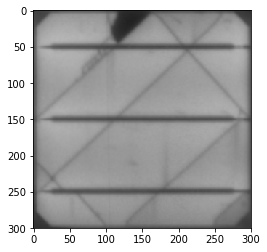

In [129]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(cv2.imread("/home/aistudio/work/images/cell0379.png"))

**2.没有问题电池**

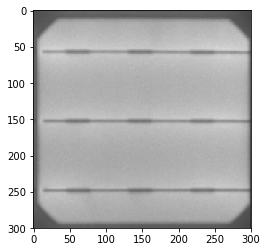

In [130]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(cv2.imread("/home/aistudio/work/images/cell1566.png"))

In [131]:
cd /home/aistudio/work/

/home/aistudio/work


In [132]:

sys.path.append('/home/aistudio/external-libraries')

In [133]:
cd /home/aistudio/work/images

/home/aistudio/work/images


In [134]:
#导入所需的包
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle
import pandas as pd
import csv

In [153]:
from paddle.io import Dataset      #引入Dataset类
class MyDataset(Dataset):           #继承Dataset类
    """
    数据集类的定义
    """
    def __init__(self, mode='train_data',transform=None):
        """
        初始化函数
        """
        super(MyDataset,self).__init__()      #注意是MyDataset 而不是Dataset
        self.data = []         #这个data属性，用来存放路径和标签
        self.transform=transform   #存放transform，也就是对图像的预处理操作。


        with open('train.csv','r') as csvFile:       #打开我们的csv文件
            reader = csv.reader(csvFile)     

            for line in reader:              
                info=line[0].split(";")     
                                           
                if info[0]=="filename":      
                    continue             
                info[0]="/home/aistudio/work/"+info[0]   
                #这时info的内容 第一项为路径  第二项为是单晶还是多晶  第三项为是否有裂纹  第四项为是否有失效区。 在本项目中不区分单晶硅与多晶硅 因此可以忽略。 第二项准备存放新的标签
                #这一段要对标签进行操作
                if info[2]=="0" and info[3]=="0":     #将无裂纹 无失效区分为第0类
                    info[1]=0
                elif info[2]=="0" and info[3]=="1":   #将无裂纹 但存在失效区分为第1类
                    info[1]=1
                elif info[2]=="1" and info[3]=="0":   #将有裂纹  无失效区分为第2类
                    info[1]=2
                elif info[2]=="1" and info[3]=="1":   #将有裂纹  且存在失效区分为第四类
                    info[1]=3                            #这里直接用else也行  为了可读性用了elif
                
                if len(info)>0:             
                    self.data.append([info[0].strip(), info[1]])    #将处理好的路径和标签  加入到我们的data属性里
            #切分数据集
            
            ratio=0.7
            offset=int(ratio*len(self.data))
            if mode=='train_data':
                self.data=self.data[:offset]
            else:
                self.data=self.data[offset:]


  #以上是初始化工作。  我们上面只是用data这么个大列表存放了一些路径+标签 而非图片。   那么，paddle的数据管道究竟如何使用呢？ 关键就在于getitem方法 
    def __getitem__(self, index):
        """
        根据索引获取单个样本
        """
        image_file, label = self.data[index]  #用传进来的索引，在data这个大列表里，找到路径和标签     
        img = Image.open(image_file)    #Pillow读入图片。 jpg图片是3通道的 png则是四通道 多一个透明度。                       这里转不转RGB其实没啥影响 因为EL照片是灰白的。         (Pillow读入HWC,RGB)
        img = np.array(img)              #将img转换为numpy数组       
        img=img.astype(np.float32) 
        img=img.reshape((1,300,300))  
        if self.transform is not None:     #检测是否要进行预处理
            img=self.transform(img)        #关于transform在数据集实例化的过程会有详细解释,暂时不用
        label = np.array([label], dtype="int64") #把标签数据类型转成int64，这里我不知道为啥，不转换数据类型就会报错。
        return img, label                   #返回照片与标签。
 

#看完了这个方法 我们来详细介绍训练数据的时候，paddle的dataset如何工作。训练时 会调用getitem方法 然后拿到图片和标签，然后传给模型。每一条数据都是这样，最终完成训练。
    def __len__(self):              #输出数据集长度
        """
        获取样本总数
        """
        return len(self.data)

In [136]:
cd /home/aistudio/work/

/home/aistudio/work


In [137]:
import paddle.nn.functional as F

from paddle.vision.transforms import Compose , ToTensor
#compose的功能是，把要做的预处理以列表组合起来。

transform = Compose([ToTensor()])    #ToTensor 自动将输入的HWC转为CHW   当然输入的CHW也会被换掉。 如果不想换则加参数。

In [141]:

train_dataset = MyDataset(mode='train_data')

test_dataset = MyDataset(mode='test_data')

In [142]:
print("训练集长度{}".format(train_dataset.__len__())) 
print("测试集长度{}".format(test_dataset.__len__())) 

训练集长度1400
测试集长度600


In [143]:
item=train_dataset[0]#拿出第一条数据
data=item[0].reshape(300,300)   #第一项为图片
label=int(item[1])              #第二项为标签
print(data)
label_list=["0无异常","1存在失效区无裂纹","2有裂纹无失效区","3有裂纹有失效区"] 
print("异常的类型为：{}".format(label_list[int(item[1])]))
plt.figure()
plt.imshow(data,cmap=plt.cm.binary)
plt.show()rfg6

SyntaxError: invalid syntax (1219614183.py, line 9)

In [144]:
class MyModel(paddle.nn.Layer):
    def __init__(self):
        super(MyModel, self).__init__()
        #(1)加一个卷积层。四个参数分别是(输入图像通道，卷积后输出图像通道数，卷积核大小，卷积步长)

        #一个filter经过一次抓取，生成一个feature map.不同的filter抓取不同特征。这里有2个filter
        #输出的尺寸：输入数据的大小-卷积核大小+2×边界填充0的数量）/移动步长+1
        #[（300-5+2*0）/1]+1=296 
        
        self.conv1 = paddle.nn.Conv2D(in_channels=1,   
                                      out_channels=6,
                                      kernel_size=5,
                                      stride=1)
        #(2)加一个池化层。 
        #输出的尺寸：（输入数据的大小-过滤器大小）/移动步长+1
        #[(296-4)/2]+1=147
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=4,
                                         stride=2)
        #（3）
        #这一层的功能是把张量拉平成一维向量。输入是多少，输出就是多少，改变的仅仅是形状。
        self.flatten=paddle.nn.Flatten(start_axis=1,stop_axis=-1)
        #（4）加一个线性层。
        #线性层的输入是6*111*111  6是因为我们的conv1有6个out_channels 111是我们池化后的输出。
        self.fc1=paddle.nn.Linear(6*147*147,100)
        #再叠一个relu
        self.relu1=paddle.nn.ReLU()
        #最后分成4类，所以是4个输出。
        self.fc2=paddle.nn.Linear(100,4)

    #正向传播过程
    def forward(self, x):     #调用之前的网络
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.flatten(x)     
        x = self.fc1(x)    
        x = self.relu1(x)
        x = self.fc2(x)
        return x

In [145]:
model=paddle.Model(MyModel())
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),    #指定优化方法，这里选择了Adam
              paddle.nn.CrossEntropyLoss(),                            #选择损失函数，这里是交叉熵
              paddle.metric.Accuracy())                                #评估，计算正确率

In [146]:
model.summary((1,1,300,300))    #模型可视化

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 1, 300, 300]]    [1, 6, 296, 296]         156      
  MaxPool2D-1    [[1, 6, 296, 296]]    [1, 6, 147, 147]          0       
   Flatten-1     [[1, 6, 147, 147]]      [1, 129654]             0       
   Linear-1        [[1, 129654]]           [1, 100]         12,965,500   
    ReLU-1           [[1, 100]]            [1, 100]              0       
   Linear-2          [[1, 100]]             [1, 4]              404      
Total params: 12,966,060
Trainable params: 12,966,060
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.34
Forward/backward pass size (MB): 5.99
Params size (MB): 49.46
Estimated Total Size (MB): 55.80
---------------------------------------------------------------------------



{'total_params': 12966060, 'trainable_params': 12966060}

In [147]:
model.fit(train_dataset,    #使用的数据
          epochs=8,         #训练的轮数
          batch_size=5,   #单次送进多少个数据         
          verbose=1)        #用进度条的形式打印日志

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/8


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 280/280 [==============================] - loss: 1.3168 - acc: 0.7121 - 153ms/step         
Epoch 2/8
step 280/280 [==============================] - loss: 1.0069 - acc: 0.7771 - 151ms/step         
Epoch 3/8
step 280/280 [==============================] - loss: 0.7034 - acc: 0.7771 - 151ms/step         
Epoch 4/8
step 280/280 [==============================] - loss: 0.5701 - acc: 0.7771 - 151ms/step         
Epoch 5/8
step 280/280 [==============================] - loss: 1.0654 - acc: 0.7771 - 152ms/step         
Epoch 6/8
step 280/280 [==============================] - loss: 0.7948 - acc: 0.7771 - 158ms/step         
Epoch 7/8
step 280/280 [==============================] - loss: 1.0734 - acc: 0.7771 - 158ms/step         
Epoch 8/8
step 280/280 [==============================] - loss: 0.9428 - acc: 0.7771 - 157ms/step         


In [149]:
model.evaluate(test_dataset)

Eval begin...
step  10/600 - loss: 0.3337 - acc: 0.9000 - 19ms/step
step  20/600 - loss: 0.3337 - acc: 0.9500 - 18ms/step
step  30/600 - loss: 0.3337 - acc: 0.8000 - 17ms/step
step  40/600 - loss: 0.3337 - acc: 0.7500 - 16ms/step
step  50/600 - loss: 0.3337 - acc: 0.7800 - 16ms/step
step  60/600 - loss: 0.3337 - acc: 0.8000 - 16ms/step
step  70/600 - loss: 1.8564 - acc: 0.7857 - 16ms/step
step  80/600 - loss: 2.5479 - acc: 0.7750 - 15ms/step
step  90/600 - loss: 0.3337 - acc: 0.7667 - 15ms/step
step 100/600 - loss: 0.3337 - acc: 0.7800 - 15ms/step
step 110/600 - loss: 2.5479 - acc: 0.7545 - 15ms/step
step 120/600 - loss: 0.3337 - acc: 0.7750 - 15ms/step
step 130/600 - loss: 1.8564 - acc: 0.7692 - 15ms/step
step 140/600 - loss: 0.3337 - acc: 0.7571 - 15ms/step
step 150/600 - loss: 0.3337 - acc: 0.7600 - 15ms/step
step 160/600 - loss: 0.3337 - acc: 0.7562 - 15ms/step
step 170/600 - loss: 1.8564 - acc: 0.7529 - 15ms/step
step 180/600 - loss: 0.3337 - acc: 0.7556 - 15ms/step
step 190/600 -

{'loss': [0.3336964], 'acc': 0.7616666666666667}

In [150]:
!pwd

/home/aistudio/work


In [151]:
model.save('Mymodel', False) 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/hapi/model.py:1988: UserWarning: 'inputs' was not specified when Model initialization, so the input shape to be saved will be the shape derived from the user's actual inputs. The input shape to be saved is [[5, 1, 300, 300]]. For saving correct input shapes, please provide 'inputs' for Model initialization.
  % self._input_info[0])


In [152]:
model_pre = paddle.jit.load("Mymodel")
label_list=["0无异常","1存在失效区无裂纹","2有裂纹无失效区","3有裂纹有失效区"]  
for i in range(100):
    pic=test_dataset[i][0]
    pic = pic[np.newaxis,:, : ,:]
    out=model_pre(pic)
    lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
    print("样本: {},被预测为:{},实际值为{}".format(i, label_list[lab],label_list[int(test_dataset[i][1])]))
    label=train_dataset[i][1].astype(np.int8)
    print("*********************************************")


样本: 0,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 1,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 2,被预测为:0无异常,实际值为2有裂纹无失效区
*********************************************
样本: 3,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 4,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 5,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 6,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 7,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 8,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 9,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 10,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 11,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 12,被预测为:0无异常,实际值为0无异常
*********************************************
样本: 13,被预测为:0无异常,实际值为0无异常
********************************************